In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("lab03.ipynb")

# Lab 3: Data Cleaning and EDA

In this lab you will be working on visualizing a dataset from the City of Berkeley containing data on calls to the Berkeley Police Department. Information about the dataset can be found [at this link](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5).


**Due Date: Tuesday, February 8, 11:59 PM PT.**

### Content Warning
This lab includes an analysis of crime in Berkeley. If you feel uncomfortable with this topic, **please contact your GSI or the instructors.**

### Lab Walk-Through
In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("LcIXTx49o2A", list = 'PLQCcNQgUcDfrG1xueBsgwDy0x5vQmi5j0', listType = 'playlist')

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *list names here*

---
## Setup

In this lab, we'll perform Exploratory Data Analysis and learn some preliminary tips for working with matplotlib (a Python plotting library). Note that we configure a custom default figure size. Virtually every default aspect of matplotlib [can be customized](https://matplotlib.org/users/customizing.html).

**Collaborators:** *list names here*

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 9)

In [ ]:
fig = plt.figure()
plt.show(fig)

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 1: Acquire the Data

**1. Obtain data**<br/>
To retrieve the dataset, we will use the `ds100_utils.fetch_and_cache` utility.

In [ ]:
# just run this cell
import ds100_utils

data_dir = 'data'
data_url = 'http://www.ds100.org/sp22/resources/assets/datasets/lab03_data_sp22.zip'
file_name = 'lab03_data_sp22.zip'

dest_path = ds100_utils.fetch_and_cache(data_url=data_url, file=file_name, data_dir=data_dir)
print(f'Located at {dest_path}')

**2. Unzip file**<br/>
We will now directly unzip the ZIP archive and start working with the uncompressed files.

In [ ]:
# just run this cell
my_zip = zipfile.ZipFile(dest_path, 'r')
my_zip.extractall(data_dir)

Note: There is no single right answer regarding whether to work with compressed files in their compressed state or to uncompress them on disk permanently. For example, if you need to work with multiple tools on the same files, or write many notebooks to analyze them—and they are not too large—it may be more convenient to uncompress them once.  But you may also have situations where you find it preferable to work with the compressed data directly.  

Python gives you tools for both approaches, and you should know how to perform both tasks in order to choose the one that best suits the problem at hand.

**3. View files**

Now, we'll use the `os` package to list all files in the `data` directory. `os.walk()` recursively traverses the directory, and `os.path.join()` creates the full pathname of each file.

If you're interested in learning more, check out the Python3 documentation pages for `os.walk` ([link](https://docs.python.org/3/library/os.html#os.walk)) and `os.path` ([link](https://docs.python.org/3/library/os.path.html#os.path.join)).

We use Python 3 [format strings](https://docs.python.org/3/tutorial/inputoutput.html) to nicely format the printed variables `dpath` and `fpath`.

In [ ]:
# just run this cell
import os

for root, directories, filenames in os.walk(data_dir):
    # first, print out all directories
    for directory in directories:
        dpath = os.path.join(root, directory)
        print(f"d {dpath}")
        
    # next, print out all files
    for filename in filenames:  
        fpath = os.path.join(root,filename)
        print(f"  {fpath}")

In this Lab, we'll be working with the `Berkeley_PD_-_Calls_for_Service.csv` file. Feel free to check out the other files, though.

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 2: Clean and Explore the Data

Let's now load the CSV file we have into a `pandas.DataFrame` object and start exploring the data.

In [ ]:
# just run this cell
calls = pd.read_csv("data/Berkeley_PD_-_Calls_for_Service.csv")
calls.head()

We see that the fields include a case number, the offense type, the date and time of the offense, the "CVLEGEND" which appears to be related to the offense type, a "CVDOW" which has no apparent meaning, a date added to the database, and the location spread across four fields. We can read more about each field from the City of the Berkeley's [open dataset webpage](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5).

Let's also check some basic information about this DataFrame using the `DataFrame.info` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html)) and `DataFrame.describe` methods ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html)).

In [ ]:
# df.info() displays 
# name and type of each column,
# number of non-null entries, and
# size of dataframe
calls.info()

Note that the `BLKADDR` column only has 2612 non-null entries, while the other columns all have 2632 entries. This is because the `.info()` method only counts non-null entries.

In [ ]:
calls.describe()

Notice that the functions above reveal type information for the columns, as well as some basic statistics about the numerical columns found in the DataFrame. However, we still need more information about what each column represents. Let's explore the data further in Question 1.

Before we go over the fields to see their meanings, the cell below will verify that all the events happened in Berkeley by grouping on the `City` and `State` columns. You should see that all of our data falls into one group.

In [ ]:
calls.groupby(["City","State"]).count()

When we called `head()` on the Dataframe `calls`, it seemed like `OFFENSE` and `CVLEGEND` both contained information about the type of event reported. What is the difference in meaning between the two columns? One way to probe this is to look at the `value_counts` for each Series.

In [ ]:
calls['OFFENSE'].value_counts().head(10)

In [ ]:
calls['CVLEGEND'].value_counts().head(10)

It seems like `OFFENSE` is more specific than `CVLEGEND`, e.g. "LARCENY" vs. "THEFT FELONY (OVER $950)". If you're unfamiliar with the term, "larceny" is a legal term for theft of personal property.

To get a sense of how many subcategories there are for each `OFFENSE`, we will set `calls_by_cvlegend_and_offense` equal to a multi-indexed series where the data is first indexed on the `CVLEGEND` and then on the `OFFENSE`, and the data is equal to the number of offenses in the database that match the respective `CVLEGEND` and `OFFENSE`. As you can see, `calls_by_cvlegend_and_offense["LARCENY", "THEFT FROM PERSON"]` returns 8 which means there are 8 instances of larceny with offense of type "THEFT FROM PERSON" in the database.

In [ ]:
calls_by_cvlegend_and_offense = calls.groupby(["CVLEGEND", "OFFENSE"]).size()
calls_by_cvlegend_and_offense["LARCENY", "THEFT FROM PERSON"]

<br/>

<hr style="border: 1px solid #fdb515;" />

## Question 1

In the cell below, set `answer1` equal to a list of strings corresponding to the possible values for `OFFENSE` when `CVLEGEND` is "LARCENY". You can type the answer manually, or you can create an expression that automatically extracts the names.

<!--
BEGIN QUESTION
name: q1
-->

In [149]:
answer1 = list(calls[calls['CVLEGEND']=='LARCENY']['OFFENSE'].unique())
answer1

['THEFT MISD. (UNDER $950)', 'THEFT FELONY (OVER $950)', 'THEFT FROM PERSON']

In [ ]:
grader.check("q1")

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 3: Visualize the Data


### Matplotlib demo

You've seen some `matplotlib` in this class already, but now we will explain how to work with the object-oriented plotting API mentioned in this [matplotlib.pyplot tutorial](https://matplotlib.org/tutorials/introductory/pyplot.html) useful. In matplotlib, plotting occurs on a set of Axes which are associated with a Figure. An analogy is that on a blank canvas (Figure), you choose a location to plot (`Axes`) and then fill it in (plot).

There are two approaches to labeling and manipulating figure contents, which we'll discuss below. Approach 1 is closest to the plotting paradigm of MATLAB, the namesake of matplotlib; Approach 2 is also common because many matplotlib-based packages (such as Seaborn) explicitly return the current set of axes after plotting data. Both are essentially equivalent, and at the end of this class you'll be comfortable with both. 

**Approach 1**: matplotlib (or Seaborn) will auto-plot onto the current set of Axes or (if none exists) create a new figure/set of default axes. You can plot data using methods from `plt`, which is shorthand for the `matplotlib.pyplot` package. Then subsequent `plt` calls all edit the same set of default-created axes.

**Approach 2**:  
After creating the initial plot, you can also use `plt.gca()` to explicitly get the current set of axes, and then edit those specific axes using axes methods. Note the method naming is slightly different!


As an example of the built-in plotting functionality of pandas, the following example uses `plot` method of the `Series` class to generate a `barh` plot type to visually display the value counts for `CVLEGEND`.

There are also many other plots that we will explore throughout the lab.

**Side note:** Pandas also offers basic functionality for plotting. For example, the `DataFrame` and `Series` classes both have a `plot` method, which uses matplotlib under the hood. For now we'll focus on matplotlib itself so you get used to the syntax, but just know that convenient Pandas plotting methods exist for your own future data science exploration.

Below, we show both approaches by generating a horizontal bar plot to visually display the value counts for `CVLEGEND`. See the `barh`[documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barh.html?highlight=barh#matplotlib.pyplot.barh) for more details.

In [ ]:
# DEMO CELL: assign demo to 1 or 2.
demo = 2


calls_cvlegend = calls['CVLEGEND'].value_counts()

if demo == 1:
    plt.barh(calls_cvlegend.index, calls_cvlegend) # creates figure and axes
    print(f"Demo {demo}: Using plt methods to update plot")
    plt.ylabel("Crime Category")               # uses most recently plotted axes
    plt.xlabel("Number of Calls")
    plt.title("Number of Calls by Crime Type")
elif demo == 2:
    print(f"Demo {demo}: Using axes methods to update plot")
    plt.barh(calls_cvlegend.index, calls_cvlegend) # creates figure and axes
    ax = plt.gca()
    ax.set_ylabel("Crime Category")
    ax.set_xlabel("Number of Calls")
    ax.set_title("Axes methods: Number of Calls by Crime Type")
else:
    print("Error: Please assign the demo variable to 1 or 2.")

plt.show()

<br/>

### An Additional Note on Plotting in Jupyter Notebooks

You may have noticed that many of our plotting code cells end with a semicolon `;` or `plt.show()`. The former prevents any extra output from the last line of the cell; the latter explicitly returns (and outputs) the figure. Try adding this to your own code in the following questions!

<br/>
<hr style="border: 1px solid #fdb515;" />

## Question 2

Now it is your turn to make a plot using `matplotlib`.  Let's start by transforming the data so that it is easier to work with.

The `CVDOW` field isn't named helpfully and it is hard to see the meaning from the data alone. According to the website [linked](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5) at the top of this notebook, `CVDOW` is actually indicating the day that events happened. 0->Sunday, 1->Monday ... 6->Saturday. 

## Question 2a

Add a new column `Day` into the `calls` dataframe that has the string weekday (eg. 'Sunday') for the corresponding value in CVDOW. For example, if the first 3 values of `CVDOW` are `[3, 6, 0]`, then the first 3 values of the `Day` column should be `["Wednesday", "Saturday", "Sunday"]`.

**Hint:** *Try using the [Series.map](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html) function on `calls["CVDOW"]`.  Can you assign this to the new column `calls["Day"]`?*

<!--
BEGIN QUESTION
name: q2a
-->

In [152]:
days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
day_indices = range(7)
indices_to_days_dict = dict(zip(day_indices, days)) # Should look like {0:"Sunday", 1:"Monday", ..., 6:"Saturday"}
calls['Day']=calls['CVDOW'].map(indices_to_days_dict)
calls

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Hour,Lat,Lon
0,21014296,THEFT MISD. (UNDER $950),04/01/2021 12:00:00 AM,10:58,LARCENY,4,06/15/2021 12:00:00 AM,"Berkeley, CA\n(37.869058, -122.270455)",NaN,Berkeley,CA,Thursday,10,37.869058,-122.270455
1,21014391,THEFT MISD. (UNDER $950),04/01/2021 12:00:00 AM,10:38,LARCENY,4,06/15/2021 12:00:00 AM,"Berkeley, CA\n(37.869058, -122.270455)",NaN,Berkeley,CA,Thursday,10,37.869058,-122.270455
2,21090494,THEFT MISD. (UNDER $950),04/19/2021 12:00:00 AM,12:15,LARCENY,1,06/15/2021 12:00:00 AM,"2100 BLOCK HASTE ST\nBerkeley, CA\n(37.864908,...",2100 BLOCK HASTE ST,Berkeley,CA,Monday,12,37.864908,-122.267289
3,21090204,THEFT FELONY (OVER $950),02/13/2021 12:00:00 AM,17:00,LARCENY,6,06/15/2021 12:00:00 AM,"2600 BLOCK WARRING ST\nBerkeley, CA\n(37.86393...",2600 BLOCK WARRING ST,Berkeley,CA,Saturday,17,37.863934,-122.250262
4,21090179,BURGLARY AUTO,02/08/2021 12:00:00 AM,6:20,BURGLARY - VEHICLE,1,06/15/2021 12:00:00 AM,"2700 BLOCK GARBER ST\nBerkeley, CA\n(37.86066,...",2700 BLOCK GARBER ST,Berkeley,CA,Monday,6,37.86066,-122.253407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2627,20058742,BURGLARY RESIDENTIAL,12/21/2020 12:00:00 AM,12:45,BURGLARY - RESIDENTIAL,1,06/15/2021 12:00:00 AM,"1300 BLOCK UNIVERSITY AVE\nBerkeley, CA\n(37.8...",1300 BLOCK UNIVERSITY AVE,Berkeley,CA,Monday,12,37.869764,-122.28655
2628,21008017,BRANDISHING,02/24/2021 12:00:00 AM,15:06,WEAPONS OFFENSE,3,06/15/2021 12:00:00 AM,"100 BLOCK SEAWALL DR\nBerkeley, CA\n(37.863611...",100 BLOCK SEAWALL DR,Berkeley,CA,Wednesday,15,37.863611,-122.317566
2629,21013239,THEFT FELONY (OVER $950),03/24/2021 12:00:00 AM,0:00,LARCENY,3,06/15/2021 12:00:00 AM,"2800 BLOCK HILLEGASS AVE\nBerkeley, CA\n(37.85...",2800 BLOCK HILLEGASS AVE,Berkeley,CA,Wednesday,0,37.85968,-122.255796
2630,21018143,THEFT MISD. (UNDER $950),04/24/2021 12:00:00 AM,18:35,LARCENY,6,06/15/2021 12:00:00 AM,"2500 BLOCK TELEGRAPH AVE\nBerkeley, CA\n(37.86...",2500 BLOCK TELEGRAPH AVE,Berkeley,CA,Saturday,18,37.864827,-122.258577


In [153]:
grader.check("q2a")

q2a results: All test cases passed!

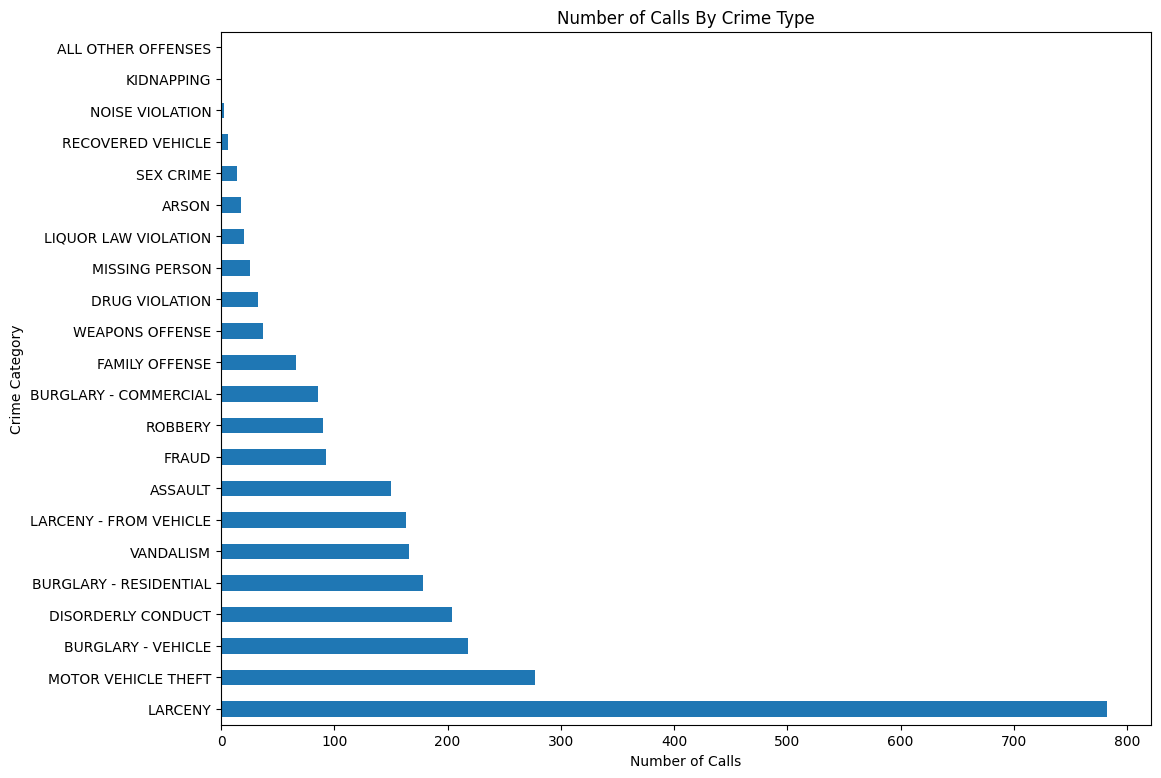

In [154]:
# just run this example cell
ax = calls['CVLEGEND'].value_counts().plot(kind='barh')
ax.set_ylabel("Crime Category")
ax.set_xlabel("Number of Calls")
ax.set_title("Number of Calls By Crime Type");

**Challenge (OPTIONAL):** You could also accomplish this part as a table left join with `pd.merge` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html?highlight=merge#pandas.merge)), instead of using `Series.map`. You would need to merge `calls` with a new dataframe that just contains the days of the week. If you have time, try it out in the below cell!

In [ ]:
# scratch space for optional challenge
dow_df = pd.DataFrame(days, columns=["Day"]).reset_index().rename(columns={"index":"CVDOW"})
calls.merge(dow_df,how='left',on='CVDOW').drop(columns=['Day_y']).rename(columns={"Day_x":"Day"})


---
## Question 2b

Now let's look at the `EVENTTM` column which indicates the time for events. Since it contains hour and minute information, let's extract the hour info and create a new column named `Hour` in the `calls` dataframe. You should save the hour as an `int`.


**Hint:** *Your code should only require one line*.<br/>
**Hint 2:** The vectorized `Series.str[ind]` performs integer indexing on an array entry.

<!--
BEGIN QUESTION
name: q2b
-->

In [155]:
calls['Hour']=calls['EVENTTM'].str.split(":",expand=True)[0].astype(int)
calls["Hour"]

0       10
1       10
2       12
3       17
4        6
        ..
2627    12
2628    15
2629     0
2630    18
2631     2
Name: Hour, Length: 2632, dtype: int32

In [ ]:
grader.check("q2b")

---
## Question 2c

Using `matplotlib`, construct a line plot with the count of the number of calls (entries in the table) for each hour of the day  **ordered by the time** (eg. `12:00 AM`, `1:00 AM`, ...). Please use the provided variable `hours` in your answer. Be sure that your axes are labeled and that your plot is titled.

**Hint**: Check out the `plt.plot` method in the matplotlib [tutorial](https://matplotlib.org/stable/tutorials/introductory/pyplot.html#intro-to-pyplot), as well as our demo above.

<!--
BEGIN QUESTION
name: q2c

-->

In [ ]:
c_2c=calls.copy()
hours = list(range(24))
y=c_2c.groupby('Hour').size()
plt.plot(hours,y)
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title('number of calls for each hour of the day')



# Leave this for grading purposes
ax_3d = plt.gca()

In [ ]:
grader.check("q2c")



To better understand the time of day a report occurs we could **stratify the analysis by the day of the week.**  To do this we will use **violin plots** (a variation of a **box plot**), which you will learn in more detail next week.

For now, just know that a violin plot shows an estimated distribution of quantitative data (e.g., distribution of calls by hour) over a categorical variable (day of the week). More calls occur in hours corresponding to the fatter part of each violin; the median hour of all calls in a particular day is marked by the white dot in the corresponding violin.

In [ ]:
# for now, just run this cell.
# we will learn the seaborn visualization library next week.

import seaborn as sns
ax = sns.violinplot(data=calls.sort_values("CVDOW"),
                    x="Day", y="Hour",
                    saturation=0.5, palette="Set2")
ax.set_title("Stratified Analysis of Phone Calls by Day");

---
## Question 2d

Based on your line plot and our violin plot above, what observations can you make about the patterns of calls? Here are some dimensions to consider:
* Are there more calls in the day or at night?
* What are the most and least popular times?
* Do call patterns vary by day of the week?

<!--
BEGIN QUESTION
name: q2d
-->

_Type your answer here, replacing this text._

<br/>
<hr style="border: 1px solid #fdb515;" />

## Question 3
In this last part of the lab, let's extract the GPS coordinates (latitude, longitude) from the `Block_Location` of each record.

In [ ]:
# an example block location entry
calls.loc[4, 'Block_Location']

---
## Question 3a: Regular Expressions


Use regular expressions to create a dataframe `calls_lat_lon` that has two columns titled `Lat` and `Lon`, containing the respective latitude and longitude of each record in `calls`. You should use the `Block_Location` column to extract the latitude and longitude coordinates.

**Hint**: Check out the `Series.str.extract` [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.extract.html?highlight=extract#pandas.Series.str.extract).


<!--
BEGIN QUESTION
name: q3a
-->

In [121]:
calls_lat_lon = calls['Block_Location'].str.extractall(r'(\d+\.\d+).*(-\d+\.\d+)').rename(columns={0:'Lat',1:'Lon'})
calls_lat_lon.head(10)

,,Lat,Lon
,match,,
0,0,37.869058,-122.270455
1,0,37.869058,-122.270455
2,0,37.864908,-122.267289
3,0,37.863934,-122.250262
4,0,37.86066,-122.253407
5,0,37.881957,-122.269551
6,0,37.867426,-122.269138
7,0,37.858116,-122.268002
8,0,37.868355,-122.274953


In [ ]:
grader.check("q3a")

---

## Question 3b: Join Tables

Let's include the GPS data into our `calls` data. In the below cell, use `calls_lat_lon` to add two new columns called `Lat` and `Lon` to the `calls` dataframe.

**Hint**: `pd.merge` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html?highlight=merge#pandas.DataFrame.merge)) could be useful here. Note that the order of records in `calls` and `calls_lat_lon` are the same.

<!--
BEGIN QUESTION
name: q3b
-->

In [131]:
calls['Lat']=list(calls_lat_lon['Lat'])
calls['Lon']=list(calls_lat_lon['Lon'])
calls.sample(5)      # random rows

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Hour,Lat,Lon
2442,21021889,THEFT FELONY (OVER $950),05/17/2021 12:00:00 AM,22:12,LARCENY,1,06/15/2021 12:00:00 AM,"2200 BLOCK ACTON ST\nBerkeley, CA\n(37.866924,...",2200 BLOCK ACTON ST,Berkeley,CA,Monday,22,37.866924,-122.283899
624,20057207,ASSAULT/BATTERY MISD.,12/17/2020 12:00:00 AM,16:50,ASSAULT,4,06/15/2021 12:00:00 AM,"2100 BLOCK SHATTUCK AVE\nBerkeley, CA\n(37.871...",2100 BLOCK SHATTUCK AVE,Berkeley,CA,Thursday,16,37.871167,-122.268285
739,21008914,BURGLARY RESIDENTIAL,03/01/2021 12:00:00 AM,11:25,BURGLARY - RESIDENTIAL,1,06/15/2021 12:00:00 AM,"800 BLOCK HEARST AVE\nBerkeley, CA\n(37.869084...",800 BLOCK HEARST AVE,Berkeley,CA,Monday,11,37.869084,-122.299245
461,21018664,VEHICLE STOLEN,04/27/2021 12:00:00 AM,22:00,MOTOR VEHICLE THEFT,2,06/15/2021 12:00:00 AM,"2800 BLOCK HILLEGASS AVE\nBerkeley, CA\n(37.85...",2800 BLOCK HILLEGASS AVE,Berkeley,CA,Tuesday,22,37.85968,-122.255796
2602,21007269,THEFT MISD. (UNDER $950),02/17/2021 12:00:00 AM,5:30,LARCENY,3,06/15/2021 12:00:00 AM,"1200 BLOCK GRIZZLY PEAK BLVD\nBerkeley, CA\n(3...",1200 BLOCK GRIZZLY PEAK BLVD,Berkeley,CA,Wednesday,5,37.889989,-122.252226


In [132]:
grader.check("q3b")

q3b results: All test cases passed!

---
## Question 3c: Check for Missing Values

It seems like every record has valid GPS coordinates:

In [133]:
# just run this cell
# fraction of valid lat/lon entries
(~calls[["Lat", "Lon"]].isna()).mean()

Lat    1.0
Lon    1.0
dtype: float64

However, a closer examination of the data reveals something else. Here's the first few records of our data again:

In [134]:
calls.head(5)

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Hour,Lat,Lon
0,21014296,THEFT MISD. (UNDER $950),04/01/2021 12:00:00 AM,10:58,LARCENY,4,06/15/2021 12:00:00 AM,"Berkeley, CA\n(37.869058, -122.270455)",NaN,Berkeley,CA,Thursday,10,37.869058,-122.270455
1,21014391,THEFT MISD. (UNDER $950),04/01/2021 12:00:00 AM,10:38,LARCENY,4,06/15/2021 12:00:00 AM,"Berkeley, CA\n(37.869058, -122.270455)",NaN,Berkeley,CA,Thursday,10,37.869058,-122.270455
2,21090494,THEFT MISD. (UNDER $950),04/19/2021 12:00:00 AM,12:15,LARCENY,1,06/15/2021 12:00:00 AM,"2100 BLOCK HASTE ST\nBerkeley, CA\n(37.864908,...",2100 BLOCK HASTE ST,Berkeley,CA,Monday,12,37.864908,-122.267289
3,21090204,THEFT FELONY (OVER $950),02/13/2021 12:00:00 AM,17:00,LARCENY,6,06/15/2021 12:00:00 AM,"2600 BLOCK WARRING ST\nBerkeley, CA\n(37.86393...",2600 BLOCK WARRING ST,Berkeley,CA,Saturday,17,37.863934,-122.250262
4,21090179,BURGLARY AUTO,02/08/2021 12:00:00 AM,6:20,BURGLARY - VEHICLE,1,06/15/2021 12:00:00 AM,"2700 BLOCK GARBER ST\nBerkeley, CA\n(37.86066,...",2700 BLOCK GARBER ST,Berkeley,CA,Monday,6,37.86066,-122.253407


There is another field that tells us whether we have a valid `Block_Location` entry per record---i.e., with GPS coordinates (latitude, longitude) that match the listed block location. What is it?

In the below cell, use the field you found to create a new dataframe, `missing_lat_lon`, that contains only the rows of `calls` that have invalid latitude and longitude data. Your new dataframe should have all the same columns of `calls`.

<!--
BEGIN QUESTION
name: q3c
-->

In [143]:
missing_lat_lon = calls[calls['Lat']=='37.869058'][calls['Lon']=='-122.270455']

missing_lat_lon.head()

C:\Users\stell\AppData\Local\Temp\ipykernel_20520\1275069815.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  missing_lat_lon = calls[calls['Lat']=='37.869058'][calls['Lon']=='-122.270455']


,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Hour,Lat,Lon
0,21014296,THEFT MISD. (UNDER $950),04/01/2021 12:00:00 AM,10:58,LARCENY,4,06/15/2021 12:00:00 AM,"Berkeley, CA\n(37.869058, -122.270455)",NaN,Berkeley,CA,Thursday,10,37.869058,-122.270455
1,21014391,THEFT MISD. (UNDER $950),04/01/2021 12:00:00 AM,10:38,LARCENY,4,06/15/2021 12:00:00 AM,"Berkeley, CA\n(37.869058, -122.270455)",NaN,Berkeley,CA,Thursday,10,37.869058,-122.270455
215,21019124,BURGLARY RESIDENTIAL,04/30/2021 12:00:00 AM,10:00,BURGLARY - RESIDENTIAL,5,06/15/2021 12:00:00 AM,"Berkeley, CA\n(37.869058, -122.270455)",NaN,Berkeley,CA,Friday,10,37.869058,-122.270455
260,21000289,VEHICLE STOLEN,01/01/2021 12:00:00 AM,12:00,MOTOR VEHICLE THEFT,5,06/15/2021 12:00:00 AM,"Berkeley, CA\n(37.869058, -122.270455)",NaN,Berkeley,CA,Friday,12,37.869058,-122.270455
633,21013362,BURGLARY AUTO,03/27/2021 12:00:00 AM,4:20,BURGLARY - VEHICLE,6,06/15/2021 12:00:00 AM,"Berkeley, CA\n(37.869058, -122.270455)",NaN,Berkeley,CA,Saturday,4,37.869058,-122.270455


In [144]:
grader.check("q3c")

q3c results: All test cases passed!

---

## Question 3d: Check Missing Values

Now let us explore if there is a pattern to which types of records have missing latitude and longitude entries.

We've implemented the plotting code for you below, but read through it and verify you understand what we're doing (we've thrown in a bonus `plt.subplots()` call, documentation [here](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html#stacking-subplots-in-one-direction)).

C:\Users\stell\AppData\Local\Temp\ipykernel_20520\1218153592.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  missing_by_time = (pd.to_datetime(missing_lat_lon['EVENTDT'])


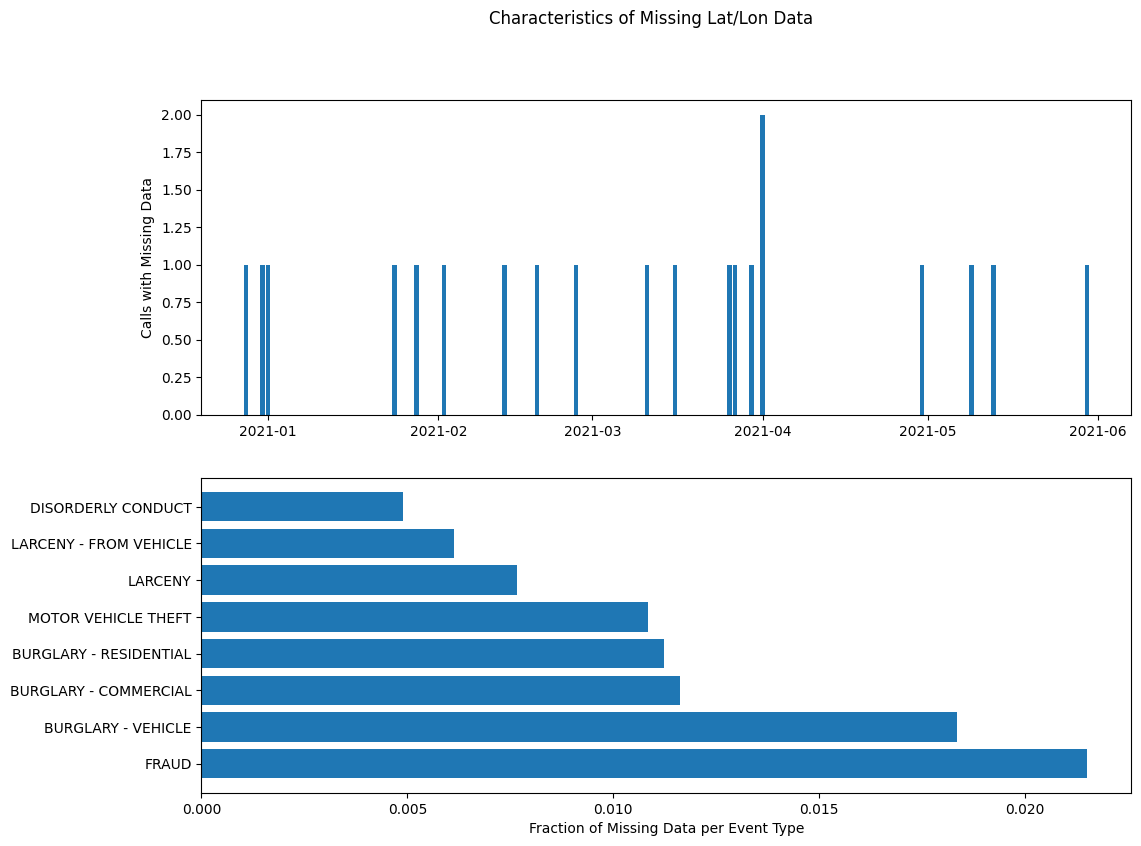

In [145]:
# just run this cell
missing_by_time = (pd.to_datetime(missing_lat_lon['EVENTDT'])
                   .value_counts()
                   .sort_index()
                  )
missing_by_crime = (missing_lat_lon['CVLEGEND']
                    .value_counts() 
                    / calls['CVLEGEND'].value_counts()
                   ).dropna().sort_values(ascending=False)

fig, ax = plt.subplots(2)
ax[0].bar(missing_by_time.index, missing_by_time)
ax[0].set_ylabel("Calls with Missing Data")
ax[1].barh(missing_by_crime.index, missing_by_crime)
ax[1].set_xlabel("Fraction of Missing Data per Event Type")
fig.suptitle("Characteristics of Missing Lat/Lon Data")
plt.show()

<!--
BEGIN QUESTION
name: q3d
-->

Based on the plots above, are there any patterns among entries that are missing latitude/longitude data? The dataset information [linked](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5) at the top of this notebook may also give more context.

_Type your answer here, replacing this text._

## Question 3d: Explore

The below cell plots a map of phonecalls by GPS coordinates (latitude, longitude); we drop missing location data.

In [146]:
# just run this cell
import folium
import folium.plugins

SF_COORDINATES = (37.87, -122.28)
sf_map = folium.Map(location=SF_COORDINATES, zoom_start=13)
locs = calls.drop(missing_lat_lon.index)[['Lat', 'Lon']].astype('float').values
heatmap = folium.plugins.HeatMap(locs.tolist(), radius=10)
sf_map.add_child(heatmap)

Based on the above map, what could be some **drawbacks** of using the location fields in this dataset to draw conclusions about crime in Berkeley? Here are some sub-questions to consider:
* Is campus really the safest place to be?
* Why are all the calls located on the street and often at intersections?

<!--
BEGIN QUESTION
name: q3d
-->

_Type your answer here, replacing this text._

<br/>

<hr style="border: 5px solid #003262;" />

**Important**: To make sure the test cases run correctly, click `Kernel>Restart & Run All` and make sure all of the test cases are still passing. Doing so will submit your code for you. 

If your test cases are no longer passing after restarting, it's likely because you're missing a variable, or the modifications that you'd previously made to your DataFrame are no longer taking place (perhaps because you deleted a cell). 

You may submit this assignment as many times as you'd like before the deadline.

**You must restart and run all cells before submitting. Otherwise, you may pass test cases locally, but not on our servers. We will not entertain regrade requests of the form, “my code passed all of my local test cases, but failed the autograder”.**

## Congratulations!

Congrats! You are finished with this lab.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [147]:
grader.check_all()

q1 results: All test cases passed!

q2a results: All test cases passed!

q2b results: All test cases passed!

q2c results: All test cases passed!

q3a results: All test cases passed!

q3b results: All test cases passed!

q3c results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)